In [1]:
# Import necessary PyTorch libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms


# Additional libraries for visualization and utilities
import matplotlib.pyplot as plt


import numpy as np
from unet import UNet
from unet_decoder import UNetDecoder
from echo import echo_sample, echo_loss

In [2]:
def get_device():
    """Selects the best available device for PyTorch computations.

    Returns:
        torch.device: The selected device.
    """

    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"using device: {device}")

using device: mps


In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor,Resize

transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Normalize with MNIST mean and std
])


# Load the CelebA dataset
dataset = datasets.MNIST(root='./data', download=True, transform=transform)

# Print the total number of images in the dataset
print(f"Total number of images in the dataset: {len(dataset)}")

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Print the number of images in the train and validation sets
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

Total number of images in the dataset: 60000
Number of images in the training set: 48000
Number of images in the validation set: 12000


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dims = latent_dims

        self.unet = UNet(
            n_channels=input_shape[0],
            n_classes=input_shape[0],  # Ensure the output channels match the input channels
            bilinear=True
        )

        # Output layers for mean and log variance
        self.out_mean = nn.Conv2d(input_shape[0], input_shape[0], kernel_size=1)
        self.out_log_var = nn.Conv2d(input_shape[0], input_shape[0], kernel_size=1)

    def forward(self, x):
        x = self.unet(x)
        f_x = torch.tanh(self.out_mean(x))
        log_var = torch.sigmoid(self.out_log_var(x))
        return f_x, log_var


In [5]:
class ColdDiffusionModel(nn.Module):
    def __init__(self, encoder, input_shape, T=1000):
        super(ColdDiffusionModel, self).__init__()
        self.input_shape = input_shape
        self.T = T
        self.encoder = encoder
        self.decoder = UNetDecoder(n_channels=input_shape[0])

        # Define the noise schedule
        self.alpha = self.create_noise_schedule(T)

    def create_noise_schedule(self, T):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        return alphas_cumprod

    def forward(self, x):

        # Calculate the gaussian noise tensor
        batch_size = x.shape[0]
        f_x, sx_matrix = self.encoder(x)
        epsilon = echo_sample((f_x, sx_matrix)).detach()
        z = f_x + sx_matrix * epsilon
        
        del epsilon 
        
        torch.cuda.empty_cache()

        #sample a timestep t
        t = np.random.randint(0, self.T)
        # Retrieve noise scheduler alpha_T
        alpha_t = self.alpha[t]

        # Calculate square root alphas
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        
        # Perform the weighted sum
        x_t = sqrt_alpha_t * x + sqrt_one_minus_alpha_t * z

        torch.cuda.empty_cache()

        #Calculate the timestep tensor
        t = torch.tensor([t] * x_t.size(0), dtype=torch.long).to(x_t.device)

        # Perform the reconstruction process 
        estimated_image = self.decoder(x_t,t)
        torch.cuda.empty_cache()
        return estimated_image

In [6]:
def freeze_module(module):
    for param in module.parameters():
        param.requires_grad = False

def unfreeze_module(module):
    for param in module.parameters():
        param.requires_grad = True

In [7]:
import os

def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth"):
    """Saves the model and optimizer state at the specified path."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Loads the model and optimizer state from the specified path."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {filename}, resuming training from epoch {epoch}")
        return epoch
    else:
        print(f"No checkpoint found at {filename}, starting from scratch.")
        return -1

In [9]:
import time  # Importing time to log the duration
from tqdm import tqdm


def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for data, _ in val_loader:
            data = data.to(device)
            # fx, sx_matrix = model(data)
            # mi_loss = echo_loss(sx_matrix)
            # total_val_loss += mi_loss
            estimated_image = model(data)
            reconstruction_loss = nn.functional.l1_loss(data, estimated_image)
            total_val_loss += reconstruction_loss.item()  # Accumulate the validation loss
    
    avg_val_loss = total_val_loss / len(val_loader)  # Calculate average loss
    return avg_val_loss

def train(model, optimizer, train_loader, device,start_epoch, num_epochs, filename):
    model.train()
    # freeze_module(model.encoder)

    for epoch in range(start_epoch+1, num_epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()  # Time tracking for the epoch

        print(f"Starting epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            data = data.to(device)

            # Forward pass
            estimated_image = model(data)
            # total_loss = echo_loss(sx_matrix)
            total_loss = torch.nn.functional.l1_loss(data, estimated_image)

            # Backward pass
            if not torch.isnan(total_loss).any():
                total_loss.backward()
            else:
                pass
                print(f"Warning: NaN detected in total_loss at batch {batch_idx+1}, skipping backward pass.")

            optimizer.step()  # Only step the optimizer every `accumulation_steps`
            optimizer.zero_grad()  # Reset gradients only after accumulation

            # Safe-guarding against NaN for epoch_loss
            if not torch.isnan(total_loss).any():
                epoch_loss += total_loss.item()
            else:
                epoch_loss += 0.0
                print(f"NaN detected, not adding to epoch_loss at batch {batch_idx+1}")

        # Save the model checkpoint
        save_checkpoint(epoch, model, optimizer, filename)
        
        # Average loss after training for an epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds, Avg Loss: {avg_loss}")

        # Validation phase
        avg_val_loss = validate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] validation completed, Avg Validation Loss: {avg_val_loss}")
        
    # unfreeze_module(model.encoder)
    return model


## Train model to minimize mi loss

In [12]:
# Define the input shape
input_shape = (1, 28, 28)
latent_dims = latent_dims = [64, 128, 256, 512]

# Create an instance of encoder model
encoder = Encoder(input_shape,latent_dims).to(device)

# Create the Diffuion Model
model = ColdDiffusionModel(encoder, input_shape).to(device)

# Define the optimizer 
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Define the number of epochs and loss weights
num_epochs = 50

# Filename
filename = "echo_cold_l1.pth"

# Load the model training checkpoint
start_epoch = load_checkpoint(model, optimizer, filename)

print(f"The training ended in epoch number: {start_epoch}")

# Train the model
trained_model = train(encoder, optimizer, train_loader, device, start_epoch, num_epochs, filename)

No checkpoint found at celeba_encoder.pth, starting from scratch.
The training ended in epoch number: -1
Starting epoch 1/50


Checkpoint saved at epoch 0 to celeba_encoder.pth
Epoch [1/50] completed in 7193.37 seconds, Avg Loss: 30.05862258881155
Epoch [1/50] validation completed, Avg Validation Loss: -43.540096282958984
Starting epoch 2/50


Checkpoint saved at epoch 1 to celeba_encoder.pth
Epoch [2/50] completed in 7825.98 seconds, Avg Loss: -34.57861584436683


KeyboardInterrupt: 

In [10]:
# Create the Diffuion Model
model = ColdDiffusionModel(encoder, input_shape).to(device)

# Define the optimizer 
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Filename 
filename = "echo_cold_l1.pth"

start_epoch = load_checkpoint(model, optimizer, filename)

# Train the model
trained_model = train(model, optimizer, train_loader, device, start_epoch, num_epochs, filename)

No checkpoint found at echo_cold_l1.pth, starting from scratch.
Starting epoch 1/50


Epoch 1/50:   0%|                                       | 0/375 [00:00<?, ?it/s]/root/miniconda3/envs/parthaenv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Checkpoint saved at epoch 0 to echo_cold_l1.pth
Epoch [1/50] completed in 262.33 seconds, Avg Loss: 0.1423209744989872


/root/miniconda3/envs/parthaenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/50] validation completed, Avg Validation Loss: 0.26100477837818736
Starting epoch 2/50


Checkpoint saved at epoch 1 to echo_cold_l1.pth
Epoch [2/50] completed in 252.09 seconds, Avg Loss: 0.12255473067363103
Epoch [2/50] validation completed, Avg Validation Loss: 0.09031156505993072
Starting epoch 3/50


Checkpoint saved at epoch 2 to echo_cold_l1.pth
Epoch [3/50] completed in 259.03 seconds, Avg Loss: 0.07561605255802473
Epoch [3/50] validation completed, Avg Validation Loss: 0.08798585130654751
Starting epoch 4/50


Checkpoint saved at epoch 3 to echo_cold_l1.pth
Epoch [4/50] completed in 242.15 seconds, Avg Loss: 0.06640429737170538
Epoch [4/50] validation completed, Avg Validation Loss: 0.06790604434431867
Starting epoch 5/50


Checkpoint saved at epoch 4 to echo_cold_l1.pth
Epoch [5/50] completed in 252.11 seconds, Avg Loss: 0.0558649877011776
Epoch [5/50] validation completed, Avg Validation Loss: 0.051226427322848045
Starting epoch 6/50


Checkpoint saved at epoch 5 to echo_cold_l1.pth
Epoch [6/50] completed in 255.23 seconds, Avg Loss: 0.053284491101900734
Epoch [6/50] validation completed, Avg Validation Loss: 0.04647251632698673
Starting epoch 7/50


Checkpoint saved at epoch 6 to echo_cold_l1.pth
Epoch [7/50] completed in 268.77 seconds, Avg Loss: 0.05211373343070348
Epoch [7/50] validation completed, Avg Validation Loss: 0.05890364310842879
Starting epoch 8/50


Checkpoint saved at epoch 7 to echo_cold_l1.pth
Epoch [8/50] completed in 271.73 seconds, Avg Loss: 0.04769241132835547
Epoch [8/50] validation completed, Avg Validation Loss: 0.04800962730053258
Starting epoch 9/50


Checkpoint saved at epoch 8 to echo_cold_l1.pth
Epoch [9/50] completed in 264.22 seconds, Avg Loss: 0.0443121669391791
Epoch [9/50] validation completed, Avg Validation Loss: 0.04785057387136398
Starting epoch 10/50


Checkpoint saved at epoch 9 to echo_cold_l1.pth
Epoch [10/50] completed in 266.65 seconds, Avg Loss: 0.044074936255812644
Epoch [10/50] validation completed, Avg Validation Loss: 0.037986457407315995
Starting epoch 11/50


Checkpoint saved at epoch 10 to echo_cold_l1.pth
Epoch [11/50] completed in 277.84 seconds, Avg Loss: 0.04481898020456235
Epoch [11/50] validation completed, Avg Validation Loss: 0.05340692563418378
Starting epoch 12/50


Checkpoint saved at epoch 11 to echo_cold_l1.pth
Epoch [12/50] completed in 272.98 seconds, Avg Loss: 0.04437011337776979
Epoch [12/50] validation completed, Avg Validation Loss: 0.04330075028887455
Starting epoch 13/50


Checkpoint saved at epoch 12 to echo_cold_l1.pth
Epoch [13/50] completed in 277.92 seconds, Avg Loss: 0.03967276374995708
Epoch [13/50] validation completed, Avg Validation Loss: 0.03654137890825563
Starting epoch 14/50


Checkpoint saved at epoch 13 to echo_cold_l1.pth
Epoch [14/50] completed in 266.02 seconds, Avg Loss: 0.03800988150884708
Epoch [14/50] validation completed, Avg Validation Loss: 0.03422987994123647
Starting epoch 15/50


Checkpoint saved at epoch 14 to echo_cold_l1.pth
Epoch [15/50] completed in 267.05 seconds, Avg Loss: 0.03869976848612229
Epoch [15/50] validation completed, Avg Validation Loss: 0.03358445697008295
Starting epoch 16/50


Checkpoint saved at epoch 15 to echo_cold_l1.pth
Epoch [16/50] completed in 273.66 seconds, Avg Loss: 0.03537443456550439
Epoch [16/50] validation completed, Avg Validation Loss: 0.03816520026389589
Starting epoch 17/50


Checkpoint saved at epoch 16 to echo_cold_l1.pth
Epoch [17/50] completed in 271.79 seconds, Avg Loss: 0.035559282682836056
Epoch [17/50] validation completed, Avg Validation Loss: 0.03487600122598258
Starting epoch 18/50


Checkpoint saved at epoch 17 to echo_cold_l1.pth
Epoch [18/50] completed in 273.53 seconds, Avg Loss: 0.035846908042828245
Epoch [18/50] validation completed, Avg Validation Loss: 0.033372081221735225
Starting epoch 19/50


Checkpoint saved at epoch 18 to echo_cold_l1.pth
Epoch [19/50] completed in 265.61 seconds, Avg Loss: 0.03469447027891874
Epoch [19/50] validation completed, Avg Validation Loss: 0.029990396690257687
Starting epoch 20/50


Checkpoint saved at epoch 19 to echo_cold_l1.pth
Epoch [20/50] completed in 269.38 seconds, Avg Loss: 0.03464005715151628
Epoch [20/50] validation completed, Avg Validation Loss: 0.03408877414829554
Starting epoch 21/50


Checkpoint saved at epoch 20 to echo_cold_l1.pth
Epoch [21/50] completed in 270.29 seconds, Avg Loss: 0.03282722634573777
Epoch [21/50] validation completed, Avg Validation Loss: 0.03488705975023356
Starting epoch 22/50


Checkpoint saved at epoch 21 to echo_cold_l1.pth
Epoch [22/50] completed in 268.70 seconds, Avg Loss: 0.03309197571625312
Epoch [22/50] validation completed, Avg Validation Loss: 0.032640219458002356
Starting epoch 23/50


Checkpoint saved at epoch 22 to echo_cold_l1.pth
Epoch [23/50] completed in 266.00 seconds, Avg Loss: 0.03124111179759105
Epoch [23/50] validation completed, Avg Validation Loss: 0.03355090865033104
Starting epoch 24/50


Checkpoint saved at epoch 23 to echo_cold_l1.pth
Epoch [24/50] completed in 271.85 seconds, Avg Loss: 0.03114078328261773
Epoch [24/50] validation completed, Avg Validation Loss: 0.03124344759085711
Starting epoch 25/50


Checkpoint saved at epoch 24 to echo_cold_l1.pth
Epoch [25/50] completed in 267.52 seconds, Avg Loss: 0.028998325449724992
Epoch [25/50] validation completed, Avg Validation Loss: 0.03461896770812096
Starting epoch 26/50


Checkpoint saved at epoch 25 to echo_cold_l1.pth
Epoch [26/50] completed in 266.89 seconds, Avg Loss: 0.030247027916212876
Epoch [26/50] validation completed, Avg Validation Loss: 0.02860465049347345
Starting epoch 27/50


Checkpoint saved at epoch 26 to echo_cold_l1.pth
Epoch [27/50] completed in 275.13 seconds, Avg Loss: 0.031160287780066333
Epoch [27/50] validation completed, Avg Validation Loss: 0.02871551387447943
Starting epoch 28/50


Checkpoint saved at epoch 27 to echo_cold_l1.pth
Epoch [28/50] completed in 260.65 seconds, Avg Loss: 0.029389260597527028
Epoch [28/50] validation completed, Avg Validation Loss: 0.029308358682913982
Starting epoch 29/50


Checkpoint saved at epoch 28 to echo_cold_l1.pth
Epoch [29/50] completed in 275.76 seconds, Avg Loss: 0.03093373406926791
Epoch [29/50] validation completed, Avg Validation Loss: 0.027023046386447994
Starting epoch 30/50


Checkpoint saved at epoch 29 to echo_cold_l1.pth
Epoch [30/50] completed in 275.18 seconds, Avg Loss: 0.02678582313656807
Epoch [30/50] validation completed, Avg Validation Loss: 0.03084039442399715
Starting epoch 31/50


Checkpoint saved at epoch 30 to echo_cold_l1.pth
Epoch [31/50] completed in 273.88 seconds, Avg Loss: 0.027217116783062618
Epoch [31/50] validation completed, Avg Validation Loss: 0.026267779020077372
Starting epoch 32/50


Checkpoint saved at epoch 31 to echo_cold_l1.pth
Epoch [32/50] completed in 274.16 seconds, Avg Loss: 0.02893913215895494
Epoch [32/50] validation completed, Avg Validation Loss: 0.03498779532519427
Starting epoch 33/50


Checkpoint saved at epoch 32 to echo_cold_l1.pth
Epoch [33/50] completed in 268.55 seconds, Avg Loss: 0.02834886105110248
Epoch [33/50] validation completed, Avg Validation Loss: 0.025317009597858216
Starting epoch 34/50


Checkpoint saved at epoch 33 to echo_cold_l1.pth
Epoch [34/50] completed in 273.93 seconds, Avg Loss: 0.02660774794469277
Epoch [34/50] validation completed, Avg Validation Loss: 0.0261287635509321
Starting epoch 35/50


Checkpoint saved at epoch 34 to echo_cold_l1.pth
Epoch [35/50] completed in 272.80 seconds, Avg Loss: 0.025372469084958237
Epoch [35/50] validation completed, Avg Validation Loss: 0.02783017503493961
Starting epoch 36/50


Checkpoint saved at epoch 35 to echo_cold_l1.pth
Epoch [36/50] completed in 267.34 seconds, Avg Loss: 0.026274789425234
Epoch [36/50] validation completed, Avg Validation Loss: 0.02709587814008936
Starting epoch 37/50


Checkpoint saved at epoch 36 to echo_cold_l1.pth
Epoch [37/50] completed in 276.04 seconds, Avg Loss: 0.02602455440411965
Epoch [37/50] validation completed, Avg Validation Loss: 0.026130817721578034
Starting epoch 38/50


Checkpoint saved at epoch 37 to echo_cold_l1.pth
Epoch [38/50] completed in 258.14 seconds, Avg Loss: 0.025797217878202598
Epoch [38/50] validation completed, Avg Validation Loss: 0.026282746998712102
Starting epoch 39/50


Checkpoint saved at epoch 38 to echo_cold_l1.pth
Epoch [39/50] completed in 276.52 seconds, Avg Loss: 0.024548527253170808
Epoch [39/50] validation completed, Avg Validation Loss: 0.02539497643629921
Starting epoch 40/50


Checkpoint saved at epoch 39 to echo_cold_l1.pth
Epoch [40/50] completed in 272.71 seconds, Avg Loss: 0.025944218158721923
Epoch [40/50] validation completed, Avg Validation Loss: 0.024007169886472376
Starting epoch 41/50


Checkpoint saved at epoch 40 to echo_cold_l1.pth
Epoch [41/50] completed in 273.40 seconds, Avg Loss: 0.024750207670032977
Epoch [41/50] validation completed, Avg Validation Loss: 0.026546762473484937
Starting epoch 42/50


Checkpoint saved at epoch 41 to echo_cold_l1.pth
Epoch [42/50] completed in 271.27 seconds, Avg Loss: 0.024893804964919886
Epoch [42/50] validation completed, Avg Validation Loss: 0.02631436490473595
Starting epoch 43/50


Checkpoint saved at epoch 42 to echo_cold_l1.pth
Epoch [43/50] completed in 275.86 seconds, Avg Loss: 0.02523096850514412
Epoch [43/50] validation completed, Avg Validation Loss: 0.027897465944369423
Starting epoch 44/50


Checkpoint saved at epoch 43 to echo_cold_l1.pth
Epoch [44/50] completed in 268.67 seconds, Avg Loss: 0.023480329183240733
Epoch [44/50] validation completed, Avg Validation Loss: 0.022843897738989365
Starting epoch 45/50


Checkpoint saved at epoch 44 to echo_cold_l1.pth
Epoch [45/50] completed in 270.47 seconds, Avg Loss: 0.024555062390863896
Epoch [45/50] validation completed, Avg Validation Loss: 0.02833291779252443
Starting epoch 46/50


Checkpoint saved at epoch 45 to echo_cold_l1.pth
Epoch [46/50] completed in 274.59 seconds, Avg Loss: 0.02357568446795146
Epoch [46/50] validation completed, Avg Validation Loss: 0.01994654778985584
Starting epoch 47/50


Checkpoint saved at epoch 46 to echo_cold_l1.pth
Epoch [47/50] completed in 267.34 seconds, Avg Loss: 0.02341543814291557
Epoch [47/50] validation completed, Avg Validation Loss: 0.023550225580309298
Starting epoch 48/50


Checkpoint saved at epoch 47 to echo_cold_l1.pth
Epoch [48/50] completed in 274.55 seconds, Avg Loss: 0.02594897596538067
Epoch [48/50] validation completed, Avg Validation Loss: 0.025902247115811135
Starting epoch 49/50


Checkpoint saved at epoch 48 to echo_cold_l1.pth
Epoch [49/50] completed in 273.14 seconds, Avg Loss: 0.023114223991831145
Epoch [49/50] validation completed, Avg Validation Loss: 0.021873231531378438
Starting epoch 50/50


Checkpoint saved at epoch 49 to echo_cold_l1.pth
Epoch [50/50] completed in 260.18 seconds, Avg Loss: 0.02276922165354093
Epoch [50/50] validation completed, Avg Validation Loss: 0.03026146978694708


In [11]:
# Define the input shape
input_shape = (1, 28, 28)

# Example usage
model = ColdDiffusionModel(encoder, input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = load_checkpoint(model, optimizer, filename)
print(f"The training ended in epoch number: {start_epoch}")

Checkpoint loaded from echo_cold_l1.pth, resuming training from epoch 49
The training ended in epoch number: 49


## Sampling according to Algorithm 1

In [38]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alpha, dim=0)

batch_size = 128
model.eval()

sampled_data = {}

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(tqdm(val_loader, desc="Sampling Progress:", leave=False)):
        data = data.to(device)
        f_x, sx_matrix = model.encoder(data)
        epsilon = echo_sample((f_x, sx_matrix))
        x = f_x + sx_matrix * epsilon
        for s in range(T-1, 0, -1):
            t = torch.tensor([s] * data.size(0), dtype=torch.long).to(device)
            x_hat = model.decoder(x, t)
            z_hat = (1.0 / torch.sqrt(1-alpha[s])) * (x - torch.sqrt(alpha[s]) * x_hat)
            x = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1 - alpha[s-1]) * z_hat
        
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
        
        # Store the original and sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'original_image': (data[i].cpu() * 0.3081 + 0.1307).clamp(0, 1),  # Reverse normalization for original image
                'sampled': x[i].cpu()
            }


In [39]:
filename = 'mnist_echo_cold_alg1.pt'
# Save the dictionary to a .pt file
torch.save(sampled_data, filename)

print(f"Sampled data saved to {filename}")


Sampled data saved to mnist_echo_cold_alg1.pt


In [40]:
print(len(sampled_data))

12000


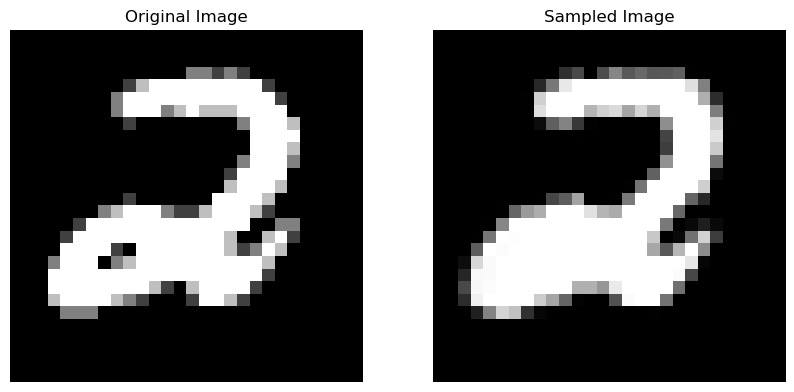

In [54]:
import torch
import matplotlib.pyplot as plt

# Load the saved data
sampled_data = torch.load(filename)

# Access a specific entry
index = 120 # Replace with the index you want to check
original_image = sampled_data[index]['original_image']
sampled_image = sampled_data[index]['sampled']



# Convert the tensor to a numpy array
original_image = original_image.cpu().numpy().transpose(1, 2, 0)
sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(sampled_image, cmap='gray')
ax[1].set_title('Sampled Image')
ax[1].axis('off')

plt.show()

## Sampling according to Algorithm 2

In [55]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alpha, dim=0)

batch_size = 128
model.eval()

sampled_data = {}

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(tqdm(val_loader, desc="Sampling Progress:", leave=False)):  # Corrected line
        data = data.to(device)
        f_x, sx_matrix = model.encoder(data)
        epsilon = echo_sample((f_x, sx_matrix))
        x = f_x + sx_matrix * epsilon
        for s in range(T-1, -1, -1):
            t = torch.tensor([s] * data.size(0), dtype=torch.long).to(device)
            x_hat = model.decoder(x, t)
            z_hat = (1.0 / torch.sqrt(1-alpha[s])) * (x - torch.sqrt(alpha[s]) * x_hat)
            D_s = torch.sqrt(alpha[s]) * x_hat + torch.sqrt(1-alpha[s]) * z_hat
            D_s_minus_one = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1-alpha[s-1]) * z_hat
            x = x - D_s + D_s_minus_one
        
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
        
        # Store the original and sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'original_image': data[i].cpu() * 0.3081 + 0.1307,  # Reverse normalization for original image
                'sampled': x[i].cpu()
            }

In [56]:
filename = 'mnist_echo_cold_alg2.pt'
# Save the dictionary to a .pt file
torch.save(sampled_data, filename)

print(f"Sampled data saved to {filename}")


Sampled data saved to mnist_echo_cold_alg2.pt


In [57]:
print(len(sampled_data))

12000


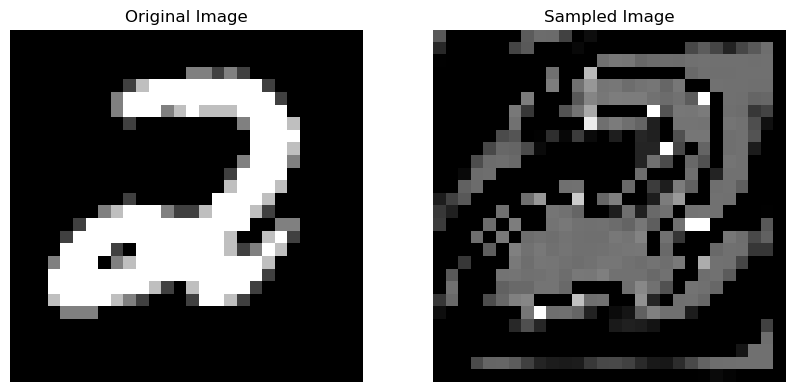

In [59]:
import torch
import matplotlib.pyplot as plt

# Load the saved data
sampled_data = torch.load(filename)

# Access a specific entry
index = 120 # Replace with the index you want to check
original_image = sampled_data[index]['original_image']
sampled_image = sampled_data[index]['sampled']



# Convert the tensor to a numpy array
original_image = original_image.cpu().numpy().transpose(1, 2, 0)
sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(sampled_image, cmap='gray')
ax[1].set_title('Sampled Image')
ax[1].axis('off')

plt.show()